<a href="https://colab.research.google.com/github/manuelboi/AI_project/blob/main/AI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq ipdb
import ipdb
import torch
import torch.nn as nn # Contains Required functions and layers
import torch.nn.functional as F # For neural network functions:
import torch.optim as optim # Contains Optimization function available in PyTorch.
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
import sys
from itertools import product
from importlib.util import find_spec

if find_spec("torchmetrics") is None:
  !pip install torchmetrics
from torchmetrics.functional import pairwise_euclidean_distance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 7.5 MB/s eta 0:00:00


['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


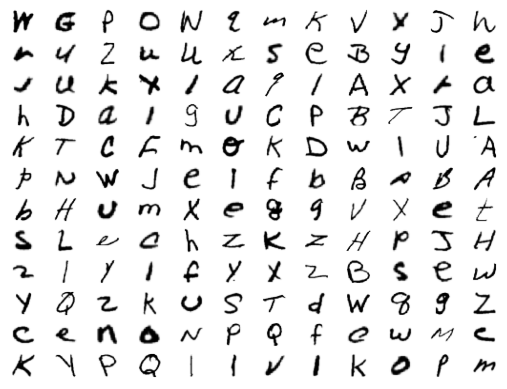

In [23]:
def show_single_letter(xi):
  xi_dim = xi.shape[0]
  vmax = torch.max(xi)

  ax = plt.gca()
  ax.grid(color='r')
  plt.xticks(range(0, xi_dim+1), fontsize=5)
  plt.yticks(range(0, xi_dim+1), fontsize=5)
  # specific values associated to "extent" attribute in order to place pixel positions precisely in the plot
  # Note: imshow plot white either if all pixels = 0 or all pixels = 255. To
  # display black when all values = 255, use vmin=0 and vmax=255
  plt.imshow(xi, extent=(0, xi_dim, xi_dim, 0), cmap='Greys', vmin=0, vmax=vmax)

def show_letters(x, n=10):
  for i in range(n**2):
    plt.subplot(n, n, i+1)
    plt.imshow(x[i], cmap="Greys")
    plt.axis("off")


DIM_IMG = 28
INPUT_SIZE = DIM_IMG ** 2
NUM_CLASSES = 26
MIN_VALUE = 0
MAX_VALUE = 255

# 124800 training set images
train_set = torchvision.datasets.EMNIST(root="data", split="letters",
                                        train=True, download=True,
                                        transform=transforms.ToTensor())

# 20800 test set images
test_set = torchvision.datasets.EMNIST(root="data", split="letters",
                                       train=False,
                                       transform=transforms.ToTensor())

# avoid to do assignment every time I execute the cell again
if "tr_images" not in globals():
  # create a tensor from a list of training samples, where each of them has been transposed and converted into a list
  # PROBLEM: not really efficient, it takes a while to execute
  tr_images = torch.tensor([image.T.tolist() for image in train_set.data])
#tr_images = train_set.data
labels = train_set.targets
for i,val in enumerate(labels):
  labels[i]=val-1

test_labels = test_set.targets
for i,val in enumerate(test_labels):
  test_labels[i]=val-1
classes = train_set.classes
print(classes)

if "test_images" not in globals():
  test_images = torch.tensor([image.T.tolist() for image in test_set.data])

show_letters(tr_images, 12)



dim_mask = 4




Understanding tensors

In [3]:
"""print(tr_images)
print(tr_images.size())
print(tr_images[0])
print(tr_images[0].size())"""

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

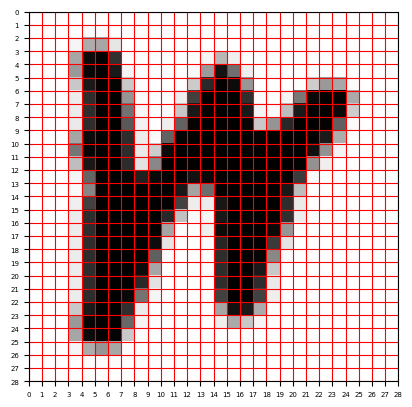

In [4]:
show_single_letter(tr_images[0])

Elia - Binarizzazione dell'immagine

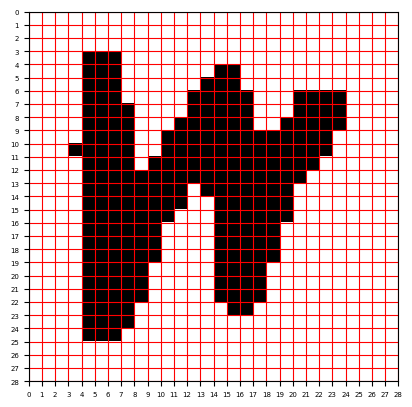

In [5]:
def binarize(image, threshold, max_value):
  return (image > threshold) * max_value

threshold = 128

tr_images_bin=torch.zeros(tr_images.size())
for i in range(tr_images.size()[0]):
  tr_images_bin[i] = binarize(tr_images[i], threshold, MAX_VALUE)

test_images_bin=torch.zeros(test_images.size())
for i in range(test_images.size()[0]):
  test_images_bin[i] = binarize(test_images[i], threshold, MAX_VALUE)

#show_letters(tr_images_bin)
show_single_letter(tr_images_bin[0])


Matteo: Implementazione della maschera per scheletrizzazione immagine.
Elia: Zoning density features

Centroids_abs: 
 [[2, 6], [2, 9], [3, 12], [4, 5], [4, 9], [4, 13], [6, 17], [7, 20], [9, 10], [10, 12], [8, 21], [10, 24], [13, 12], [18, 11], [17, 12], [22, 2], [23, 5], [22, 10], [21, 12], [24, 3], [24, 5], [24, 8]]
Centroids_rel: 
 [[0, 0], [3, 3], [3, 2], [4, 1], [0, 0], [0, 0], [0, 0], [0, 0], [1, 2], [1, 2], [1, 2], [3, 2], [4, 1], [0, 0], [0, 0], [0, 0], [2, 3], [3, 1], [0, 0], [1, 2], [3, 1], [0, 0], [0, 0], [0, 0], [2, 1], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [3, 4], [2, 1], [0, 0], [0, 0], [0, 0], [3, 3], [4, 2], [3, 3], [2, 1], [0, 0], [0, 0], [0, 0], [1, 4], [1, 2], [1, 1], [0, 0], [0, 0], [0, 0], [0, 0]]


'# tr_sample_images is a tensor, sample_centroids is an array of list ( shape: [ [ [x, y], [x, y], ... ], [ [x, y], [x, y], ... ], ... ] )\ntr_sample_images, sample_centroids = load_sample_images(tr_images_bin[0:10], dim_mask)\nprint(tr_sample_images.size())\nprint(sample_centroids) '

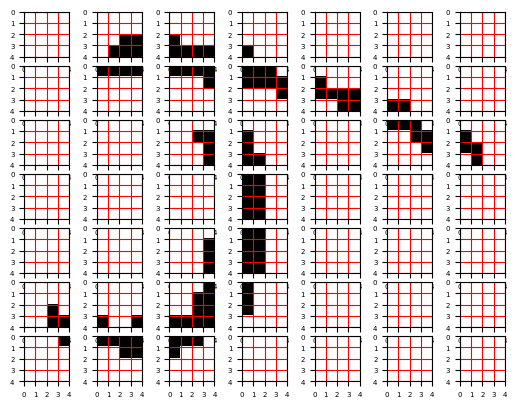

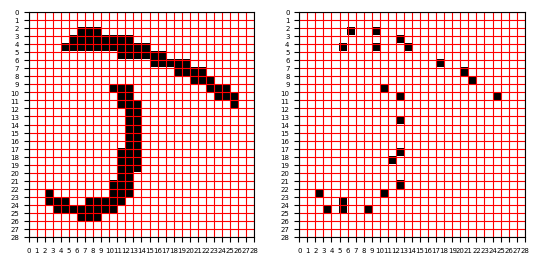

In [6]:
def compute_centroid(image):
  xis, yis = np.nonzero(image.numpy())
  if xis.size or yis.size != 0:
    return int(xis.mean()), int(yis.mean())
  return None, None



# Elia
def compute_density(image):
  return torch.sum(image).item() // MAX_VALUE



def show_subimages(image):
  n_mask_positions = INPUT_SIZE / (dim_mask ** 2)
  n_plots = int(sqrt(n_mask_positions))

  # cartesian product between "range(0, DIM_IMG, dim_mask)" and "range(0, DIM_IMG, dim_mask)"
  prod_range = product(range(0, DIM_IMG, dim_mask), repeat=2)
  # enumerate assign a counter value to every combination (i, j): (0, 0) --> 1, (0, 1) --> 2, ...
  for a, (i, j) in enumerate(prod_range, start=1):
    if a > n_mask_positions:
      break

    sub_img = image[i:i+dim_mask, j:j+dim_mask]
    plt.subplot(n_plots, n_plots, a)
    show_single_letter(sub_img)



def sampling_zoning(image):

  if DIM_IMG % dim_mask != 0:
    return None, None

  centroids_abs = []
  centroids_rel = []

  # image that will be obtained from the computed centroids
  sample_img = torch.zeros(image.size())
  # be careful: at the beginning the mask moves from left to right, then from right
  # to left and so on (right to left when "i" is odd)

  prod_range = product(range(0, DIM_IMG, dim_mask), repeat=2)
  for i, j in prod_range:
      sub_img = image[i:i+dim_mask, j:j+dim_mask]
      c_ri, c_ci = compute_centroid(sub_img)

      if (c_ri, c_ci) != (None, None):
        sample_img[c_ri+i, c_ci+j] = MAX_VALUE # max_value is 255
        centroids_abs.append([c_ri+i, c_ci+j])
        centroids_rel.append([c_ri+1, c_ci+1])
      else:
        centroids_rel.append([0, 0])

  return sample_img, centroids_abs, centroids_rel


# Elia
def density_zoning(image):
  densities = []

  # image that will be obtained from the computed densities
  density_img = torch.zeros(image.size())
  # be careful: at the beginning the mask moves from left to right, then from right
  # to left and so on (right to left everytime "i" is odd)

  prod_range = product(range(0, DIM_IMG, dim_mask), repeat=2)
  for (i, j) in prod_range:
    sub_img = image[i:i+dim_mask, j:j+dim_mask]
    density = compute_density(sub_img)
    density_img[i:i+dim_mask, j:j+dim_mask] = density
    densities.append(density)

  return density_img, densities



def zoning(image, option="sampling"):
  if DIM_IMG % dim_mask != 0:
    return None, None

  if option == "density":
    density_img, densities = density_zoning(image)
    return density_img, densities

  sample_img, centroids_abs, centroids_rel = sampling_zoning(image)
  return sample_img, centroids_abs, centroids_rel




def load_sample_images(tr_images_bin):
  tr_images_cen=torch.zeros(tr_images_bin.size())
  list_cen_abs=[]
  list_cen_rel=[]
  for i in range(tr_images_bin.size()[0]):
    tr_images_cen[i], abs, rel = zoning(tr_images_bin[i])
    list_cen_abs.append(abs)
    list_cen_rel.append(rel)

  return tr_images_cen, list_cen_abs, list_cen_rel




bin_img = tr_images_bin[10]

sample_img, centroids_abs, centroids_rel = zoning(bin_img)

# If (None, None) is returned it means an error occurred in the application
# of mask and step.
if (sample_img, centroids_abs) == (None, None):
  print(f"Error: the dimension of the mask need to be a factor of {DIM_IMG}.")
  sys.exit()


print("Centroids_abs: \n", centroids_abs)
print("Centroids_rel: \n", centroids_rel)

plt.figure(1)
show_subimages(bin_img)
plt.figure(2)
plt.subplot(121)
show_single_letter(bin_img)
plt.subplot(122)
show_single_letter(sample_img)

"""# tr_sample_images is a tensor, sample_centroids is an array of list ( shape: [ [ [x, y], [x, y], ... ], [ [x, y], [x, y], ... ], ... ] )
tr_sample_images, sample_centroids = load_sample_images(tr_images_bin[0:10], dim_mask)
print(tr_sample_images.size())
print(sample_centroids) """

In [7]:
tr_sample_images, list_centroids_abs, list_centroids_rel = load_sample_images(tr_images_bin)
ts_sample_images, ts_list_centroids_abs, ts_list_centroids_rel = load_sample_images(test_images_bin)

torch.Size([124800, 28, 28])
25


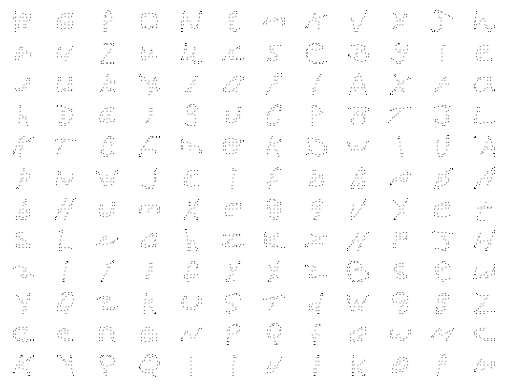

In [8]:
show_letters(tr_sample_images, 12)

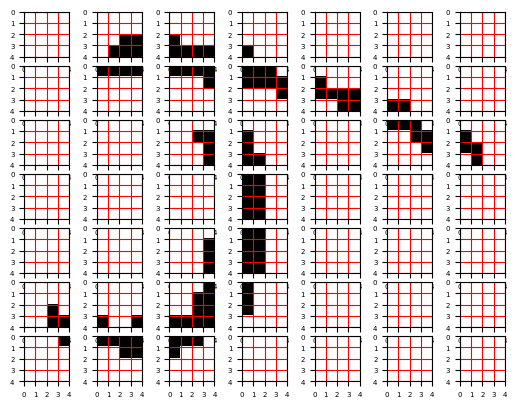

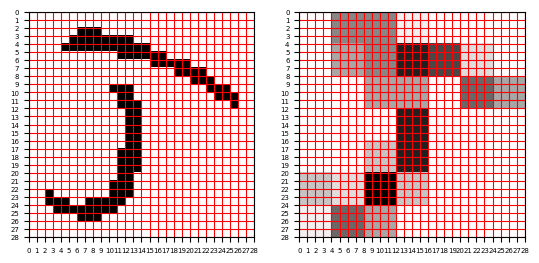

In [9]:
# zoning with density features
density_img, densities = zoning(bin_img, option="density")

if (density_img, densities) == (None, None):
  print(f"Error: the dimension of the mask need to be a factor of {DIM_IMG}.")
  sys.exit()

plt.figure(1)
show_subimages(bin_img)
plt.figure(2)
plt.subplot(121)
show_single_letter(bin_img)
plt.subplot(122)
show_single_letter(density_img)

In [10]:
def load_densities(tr_images_bin):
  tr_images_den=torch.zeros(tr_images_bin.size())
  list_densities=[]
  for i in range(tr_images_bin.size()[0]):
    tr_images_den[i], den = zoning(tr_images_bin[i], option="density")
    list_densities.append(den)

  return tr_images_den, list_densities

tr_densities, list_densities = load_densities(tr_images_bin)
ts_densities, ts_list_densities = load_densities(test_images_bin)

torch.Size([124800, 28, 28])
124800


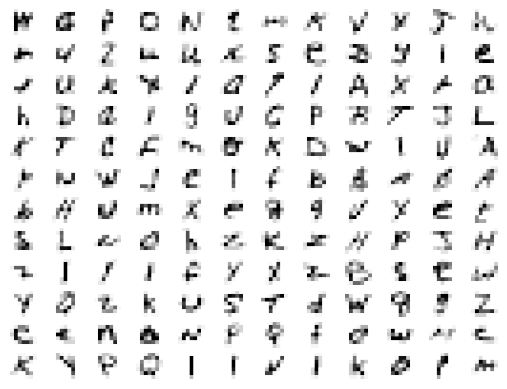

In [11]:
show_letters(tr_densities, 12)

Matteo: finding angles between pairs of centroids

Y: [[ 2  2  2  2  3  4  4  4  6  7  9 10 10 13 18 18 17 22 22 24 24 24 24 24]
 [ 4  2  4  3  4  4  4  6  7  8 10 13  8 17 22 17 21 23 21 22 24 23 24 22]]
X: [[ 6  6  9  9 12  5  9 13 17 20 10 12 24 12 11 11 12  2 10  3  3  5  5  8]
 [ 5  9  9 12 13  9 13 17 20 21 12 12 21 12 10 12 12  5 12  2  5  5  8 10]]


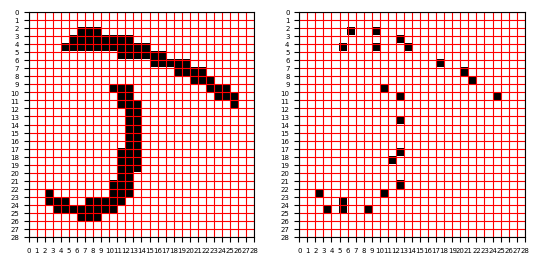

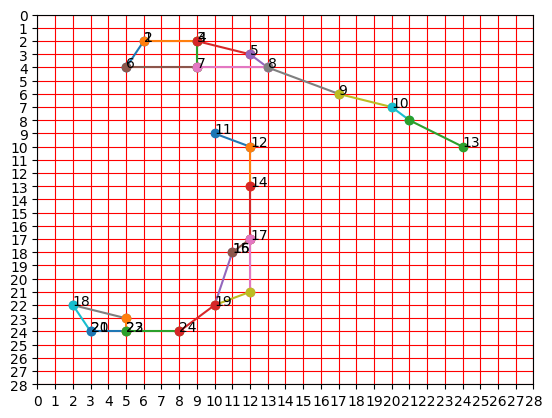

In [12]:
def angle_between(c_1, c_2, swap=False):

  # PROBLEM: WHY the condition we wish is swap = True?
  # CHECK THE CODE AGAIN

  #swap is necessary when we consider the plot of imshow
  #in imshow plot, the shown y-axis is actually the x-axis of the image, and vice versa.
  # For this reason the shape of centroid "(x, y)" in imshow plot corresponds to (y, x)
  # So you need to swap the coordinates of the parameters passed to "angle_between"

  y = torch.tensor([c_1[0, 1] - c_2[0, 1]])
  x = torch.tensor([c_1[0, 0] - c_2[0, 0]])

  if swap:
    return torch.atan2(x, y) * 180 / torch.pi
  return torch.atan2(y, x) * 180 / torch.pi


# Dictionary returned: {(c1, c2): angle_c1c2, (c1, c3): angle_c1c3, (c2, c3): angle_c3c2 ...)} <-- pairs of centroids
# it represents every segment (of the form "s = (c1, c2)"", for example) and the angle between the segment and the x axis
# PROBLEM: check again the method --> results are different than before
def rebuild_letter(sample_img):
  # "nearest subimage" concept: considering a certain subimage (same dimension of the chosen mask),
  # the nearest ones are the ones which change either the value of a row or the value of a column only,
  # and never both together, with respect to the considered subimage.

  segments = {}
  adder = dim_mask

  prod_range = product(range(0, DIM_IMG, dim_mask), repeat=2)
  for i, j in prod_range:
      new_i = i + dim_mask
      new_j = j + dim_mask
      sub_img = sample_img[i:new_i, j:new_j]

      # extract centroid coordinates from sub_img
      curr_cent = torch.nonzero(sub_img)
      # check if the tensor is not "empty"
      if torch.numel(curr_cent) != 0:
        # now current centroid refers to the actual one, considering the current i and j in sample image
        curr_cent = torch.tensor([curr_cent[0, 0].item() + i,
                                  curr_cent[0, 1].item() + j]).reshape(1, 2)

        # finding all the nearest subimages:
        # z = 0: adder = dim_mask, new_i considered; z = 1: adder = -dim_mask, new_i considered;
        # z = 2: adder = dim_mask, new_j considered; z = 3: adder = -dim_mask, new_j considered
        # neighbours for the centroid being analyzed
        for z in range(4):
          if z >= 2:
            pair_i = [i, new_i]
            pair_j = [j+adder, new_j+adder]
            pair_cond = pair_j
          else:
            pair_i = [i+adder, new_i+adder]
            pair_j = [j, new_j]
            pair_cond = pair_i

          neigh_subimg = torch.tensor([])
          neigh_cent = torch.tensor([])

          if (0 <= pair_cond[0] <= DIM_IMG - 1) and (0 <= pair_cond[1] <= DIM_IMG - 1):
            neigh_subimg = sample_img[pair_i[0]:pair_i[1], pair_j[0]:pair_j[1]]
            neigh_cent = torch.nonzero(neigh_subimg)
            if torch.numel(neigh_cent) != 0:
              neigh_cent = torch.tensor([neigh_cent[0, 0].item() + pair_i[0],
                                         neigh_cent[0, 1].item() + pair_j[0]]).reshape(1, 2)

          # neigh_cent empty --> no centroid found in that neighbour sub_img
          if torch.numel(neigh_cent) != 0:
            curr_cent_tpl = (curr_cent[0, 0].item(), curr_cent[0, 1].item())
            neigh_cent_tpl = (neigh_cent[0, 0].item(), neigh_cent[0, 1].item())

            if (curr_cent_tpl, neigh_cent_tpl) not in segments and (neigh_cent_tpl, curr_cent_tpl) not in segments:
              if pairwise_euclidean_distance(curr_cent, neigh_cent) < dim_mask + 1:
                angle = angle_between(curr_cent, neigh_cent, True).item()
                segments[(curr_cent_tpl, neigh_cent_tpl)] = angle

          adder = -(adder)

  return segments



def show_letter_from_segments(segments):
  # It shows the "rebuilt" letter starting from segments and angles found
  x1 = []
  x2 = []
  y1 = []
  y2 = []

  for couple_cents in segments:
    x1.append(couple_cents[0][1])
    y1.append(couple_cents[0][0])
    x2.append(couple_cents[1][1])
    y2.append(couple_cents[1][0])

  # ARRAY X: [[12, 16, 18, 11], [16, 18, 15, 15]]
  # ARRAY Y: [[4, 4, 10, 10], [4, 10, 14, 14]]
  # (12, 4) connects to (16,4), (16,4) to (18,10), (18,10) to (15,14)...
  x = np.array([x1, x2])
  y = np.array([y1, y2])

  print("Y:", y)
  print("X:", x)

  plt.plot(x, y, "-o")
  plt.axis([0, 28, 28, 0])
  for i in range(y.shape[1]):
    plt.annotate(f"{i+1}", (x[0, i], y[0, i]))

  plt.xticks(range(0, 29))
  plt.yticks(range(0, 29))
  ax = plt.gca()
  ax.grid(color='r')
  plt.show()




sample_img, centroids, _ = zoning(bin_img)

segments = rebuild_letter(sample_img)

# Calculate list of all segments for each sample
segments_list = []
for i in range(tr_sample_images.size()[0]):
  segments_list.append(rebuild_letter(tr_sample_images[i]))
ts_segments_list = []
for i in range(ts_sample_images.size()[0]):
  ts_segments_list.append(rebuild_letter(ts_sample_images[i]))

plt.figure(2)
plt.subplot(121)
show_single_letter(bin_img)
plt.subplot(122)
show_single_letter(sample_img)

plt.figure(3)
show_letter_from_segments(segments)



Manuel - Approssimazione dell'angolo nelle 4 direzioni

In [13]:
from enum import Enum

class Direction(Enum):
  HORIZONTAL = 1
  RIGHT_INCLINED = 2
  VERTICAL = 3
  LEFT_INCLINED = 4

  def __sub__(self, other):
    return int(self) - other

  def __div__(self, other):
    return int(self) / other

def approximate_angle(angle):
  if (angle > -22.5 and angle <= 22.5) or (angle > 157.5 and angle >= -157.5):
    approximation = Direction.HORIZONTAL
  elif (angle > 22.5 and angle <= 67.5) or (angle > -157.5 and angle <= -112.5):
    approximation = Direction.RIGHT_INCLINED
  elif (angle > 67.5 and angle <= 112.5) or (angle > -112.5 and angle <= -67.5):
    approximation = Direction.VERTICAL
  else:
    approximation = Direction.LEFT_INCLINED

  return approximation

def load_inclinations(segments_list):
  list_inclinations = []
  for sample in segments_list:
    counts = [0, 0, 0, 0]
    for segment in sample:
      dictionary_value = sample[segment]
      direction = (approximate_angle(dictionary_value))
      if direction == Direction.HORIZONTAL:
        counts[0] += 1
      elif direction == Direction.RIGHT_INCLINED:
        counts[1] += 1
      elif direction == Direction.VERTICAL:
        counts[2] += 1
      else:
        counts[3] += 1
      list_inclinations.append(counts)
  return list_inclinations




list_inclinations = load_inclinations(segments_list)
ts_list_inclinations = load_inclinations(ts_segments_list)


Manuel - Rete neurale

In [14]:
class NeuralNetwork(nn.Module):


  def __init__(self, n_input, n_output):
    super().__init__()
    self.n_input = n_input
    self.n_output = n_output
    self.mid_n = int((n_input + n_output) / 2)

    # Define Layers:
    self.l1 = nn.Linear(self.n_input, self.mid_n) # layer 1
    self.l2 = nn.Linear(self.mid_n, self.n_output) # layer 2
    self.l3 = nn.Linear(self.n_output, self.n_output) # layer 3

    # Define Activation functions:
    self.relu = nn.ReLU()
    self.softmax = nn.LogSoftmax(dim = 1)


  def forward(self, x):
    '''
    Layers: 3
    Activation Functions:
    RELU for first two layers
    Log Softmax for last layer
    '''
    x = self.l1(x)
    x = self.relu(x)
    x = self.l2(x)
    x = self.relu(x)
    x = self.l3(x)
    x = self.softmax(x)
    return x




# Define macros.
number_of_features = 151 # 49 x coordinates of the centroid, 49 y coordinates of the centroid, 49 density values, 4 number of inclinations.
number_of_outputs = 26 # Output letters of the alphabet.

# Intialize NN, loss function and optimizer
NN = NeuralNetwork(number_of_features, number_of_outputs)
criterion = nn.NLLLoss()
optimizer = optim.Adam(NN.parameters(), lr = 0.001)

Elia - Dataset creation

In [15]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self, features, labels):
    self.features = features
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.features[idx], self.labels[idx]

Manuel - Dataset Creation

In [24]:
# General purpose functions

def normalize(value, min, max):
  return (value - min) / (max - min)


def create_dataset(n_samples, images_centroids, density_values, n_inclinations):
  dataset_list = []
  for i in range(len(images_centroids)):
    list_tmp = []
    for centroid in images_centroids[i]:
        list_tmp.append(normalize(centroid[0], min_x_coordinates, max_x_coordinates))
        list_tmp.append(normalize(centroid[1], min_y_coordinates, max_y_coordinates))

    for density in density_values[i]:
      list_tmp.append(normalize(density, min_density_value, max_density_value))

    for n_inclination in n_inclinations[i]:
      list_tmp.append(normalize(n_inclination, min_n_inclinations, max_n_inclinations))

    dataset_list.append(list_tmp)

  return torch.tensor(dataset_list)


# Define min and max for each feature. If there is no centroid, coordinates x and y are 0.
min_x_coordinates = 0
max_x_coordinates = 4
min_y_coordinates = 0
max_y_coordinates = 4
min_density_value = 0
max_density_value = 16
min_n_inclinations = 0
max_n_inclinations = 84


# set CPU or GPU, if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Prepare dataset
features = create_dataset(len(list_centroids_rel), list_centroids_rel, list_densities, list_inclinations)
trainset = CustomDataset(features, labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # trainloader is what holds the data loader object which takes care of shuffling the data and constructing the batches
test_features = create_dataset(len(ts_list_centroids_rel), ts_list_centroids_rel, ts_list_densities, ts_list_inclinations)
testset = CustomDataset(test_features, test_labels)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False) # No need to shuffle test data.

Manuel - Model training

In [25]:
# Train the model
epochs = 5 # Number of times to train data
for e in range(epochs):
    for features, labels in trainloader:
        optimizer.zero_grad() # set optimizer gradients to zero:
        output = NN(features) # Intial output
        loss = criterion(output, labels) # Loss Caluclation
        loss.backward() # Pass loss function gradients to pervious layers:
        optimizer.step() # Update Weights
    print(loss.item()) # print loss for each epoch

tensor([22,  6, 15,  ..., 12, 14, 18])
1.0003232955932617
0.7802854776382446
0.6093107461929321
0.4562092423439026
0.3540043532848358


In [26]:
# Test phase
with torch.no_grad():
    correct = 0
    total = 0
    for features, labels in testloader:
        outputs = NN(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy of the model on the test images: {} %'
          .format(100.0 * correct / total))

Accuracy of the model on the test images: 83.36538696289062 %


In [ ]:
pdb on

In [ ]:
pdb off